In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')

# Set display options for better visibility
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Define a random seed for reproducibility
RANDOM_SEED = 42


# 1. DATA LOADING AND PREPARATION

In [3]:
# Load the course catalog
course_catalog = pd.read_excel('Course_Catalog.xlsx')
print("Course Catalog Overview:")
course_catalog.head()

Course Catalog Overview:


,Semester,Course Code,Class Name,Credit Hours,Pass/Fail
0,Fall,PAS 610,Clinical Medicine for Physician Assistants I,6,False
1,Fall,PAS 620,Patient Assessment for Physician Assistants I,3,False
2,Fall,PAS 630,Pharmacotherapeutics for Physician Assistants I,3,False
3,Fall,PAS 640,Pathophysiology for Physician Assistants I,3,False
4,Fall,PAS 650,Advanced Human Anatomy with Cadaver Lab for Ph...,4,False


In [4]:
print("\nTotal courses:", len(course_catalog))


Total courses: 21


In [5]:
print("\nCourse catalog info:")
course_catalog.info()


Course catalog info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Semester      21 non-null     object
 1   Course Code   21 non-null     object
 2   Class Name    21 non-null     object
 3   Credit Hours  21 non-null     int64 
 4   Pass/Fail     21 non-null     bool  
dtypes: bool(1), int64(1), object(3)
memory usage: 821.0+ bytes


In [6]:
# Load the student ID mapping (we'll need this for joining with grades data)
student_mapping = pd.read_excel('Unique_Masked_ID_Mapping.xlsx')
print("\nStudent Mapping Overview:")
student_mapping.head()


Student Mapping Overview:


,Student_Initials,Cohort_Year,Unique_Masked_ID
0,AA,2020,COH2020-01
1,WA,2020,COH2020-02
2,BA,2020,COH2020-03
3,MCHI,2020,COH2020-04
4,MCHR,2020,COH2020-05


In [7]:
print("\nTotal students:", len(student_mapping))


Total students: 120


In [8]:
print("\nStudents by cohort year:")
print(student_mapping['Cohort_Year'].value_counts())


Students by cohort year:
Cohort_Year
2020    30
2021    30
2022    30
2023    30
Name: count, dtype: int64


In [9]:
# Create a list of all non-pass/fail courses (these are the graded courses)
graded_courses = course_catalog[course_catalog['Pass/Fail'] == False]['Course Code'].tolist()
print("\nGraded courses that will be used as features:", graded_courses)
print("Total number of graded courses:", len(graded_courses))


Graded courses that will be used as features: ['PAS 610', 'PAS 620', 'PAS 630', 'PAS 640', 'PAS 650', 'PAS 672 ', 'PAS 611', 'PAS 621', 'PAS 631', 'PAS 641', 'PAS 670', 'PAS 673', 'PAS 612', 'PAS 622', 'PAS 632', 'PAS 642', 'PAS 660', 'PAS 674']
Total number of graded courses: 18


In [10]:
# For this notebook, we'll simulate grade and PANCE score data
# You can load actual grade data from your database
# Let's simulate data for 90 students (30 students x 3 cohort years)

# Function to generate synthetic student data
def generate_student_data(num_students=90, passing_threshold=350):
    # Start with student IDs from the mapping
    students = student_mapping['Unique_Masked_ID'].tolist()[:num_students]
    
    # Create an empty dataframe to store the data
    data = pd.DataFrame({'Student_ID': students})
    
    # Generate random grades for each course (between 70 and 100)
    for course in graded_courses:
        # Higher performing students tend to do well across all courses
        # Lower performing students tend to do poorly across all courses
        data[course] = np.random.normal(85, 7, size=num_students).clip(65, 100)
    
    # Add some correlation between courses in the same semester
    for semester in ['Fall', 'Winter', 'Summer']:
        semester_courses = course_catalog[course_catalog['Semester'] == semester]['Course Code'].tolist()
        semester_courses = [c for c in semester_courses if c in graded_courses]
        
        # Get base performance for each student in this semester
        base_performance = np.random.normal(0, 1, size=num_students)
        
        # Adjust grades based on base performance
        for course in semester_courses:
            data[course] = data[course] + base_performance * 3
            data[course] = data[course].clip(65, 100)  # Keep grades within realistic range
    
    # Round grades to integers
    for course in graded_courses:
        data[course] = data[course].round(1)
    
    # Generate PANCE scores (between 200 and 800, with 350 as passing)
    # Make PANCE scores correlate with course grades
    mean_grade = data[graded_courses].mean(axis=1)
    # Transform mean grade (70-100) to PANCE score range (200-800)
    data['PANCE_Score'] = (mean_grade - 70) * (600/30) + 200
    # Add some random noise
    data['PANCE_Score'] = data['PANCE_Score'] + np.random.normal(0, 50, size=num_students)
    data['PANCE_Score'] = data['PANCE_Score'].clip(200, 800).round(0).astype(int)
    
    # Add binary pass/fail column (pass if score >= 350)
    data['PANCE_Pass'] = (data['PANCE_Score'] >= passing_threshold).astype(int)
    
    # Add cohort year information
    data = data.merge(student_mapping[['Unique_Masked_ID', 'Cohort_Year']], 
                     left_on='Student_ID', right_on='Unique_Masked_ID')
    data.drop('Unique_Masked_ID', axis=1, inplace=True)
    
    return data

# Generate synthetic data
student_data = generate_student_data()

In [11]:
# Display the first few rows of the generated data
print("\nSynthetic Student Data Overview:")
student_data.head()


Synthetic Student Data Overview:


,Student_ID,PAS 610,PAS 620,PAS 630,PAS 640,PAS 650,PAS 672,PAS 611,PAS 621,PAS 631,PAS 641,PAS 670,PAS 673,PAS 612,PAS 622,PAS 632,PAS 642,PAS 660,PAS 674,PANCE_Score,PANCE_Pass,Cohort_Year
0,COH2020-01,91.4,80.2,83.7,77.4,79.2,89.7,82.9,94.0,85.2,77.7,83.3,87.5,77.5,83.6,94.0,86.7,98.5,92.4,540,1,2020
1,COH2020-02,83.1,88.0,83.3,89.0,90.9,85.0,78.1,88.8,82.2,81.7,79.7,69.7,88.7,94.8,87.6,80.8,79.5,78.8,506,1,2020
2,COH2020-03,97.8,78.6,69.0,91.9,97.2,95.4,92.8,70.9,98.0,94.0,80.1,97.2,79.4,86.3,93.6,97.1,85.0,84.1,584,1,2020
3,COH2020-04,93.1,79.3,85.3,83.5,76.7,95.7,89.2,84.5,82.3,76.0,91.9,87.5,87.7,87.4,84.1,93.9,95.7,82.4,582,1,2020
4,COH2020-05,70.8,88.0,86.8,82.2,88.5,94.8,91.5,90.0,99.4,86.9,90.6,78.4,96.3,88.5,84.8,86.5,75.6,78.8,576,1,2020


In [12]:
print("\nData shape:", student_data.shape)
print("\nPANCE pass rate:", student_data['PANCE_Pass'].mean())
print("\nPANCE score statistics:")
student_data['PANCE_Score'].describe()


Data shape: (90, 22)

PANCE pass rate: 0.9555555555555556

PANCE score statistics:


count     90.000000
mean     507.166667
std       74.268606
min      304.000000
25%      462.250000
50%      510.500000
75%      557.500000
max      660.000000
Name: PANCE_Score, dtype: float64


# 2. EXPLORATORY DATA ANALYSIS (EDA)


--- EXPLORATORY DATA ANALYSIS ---



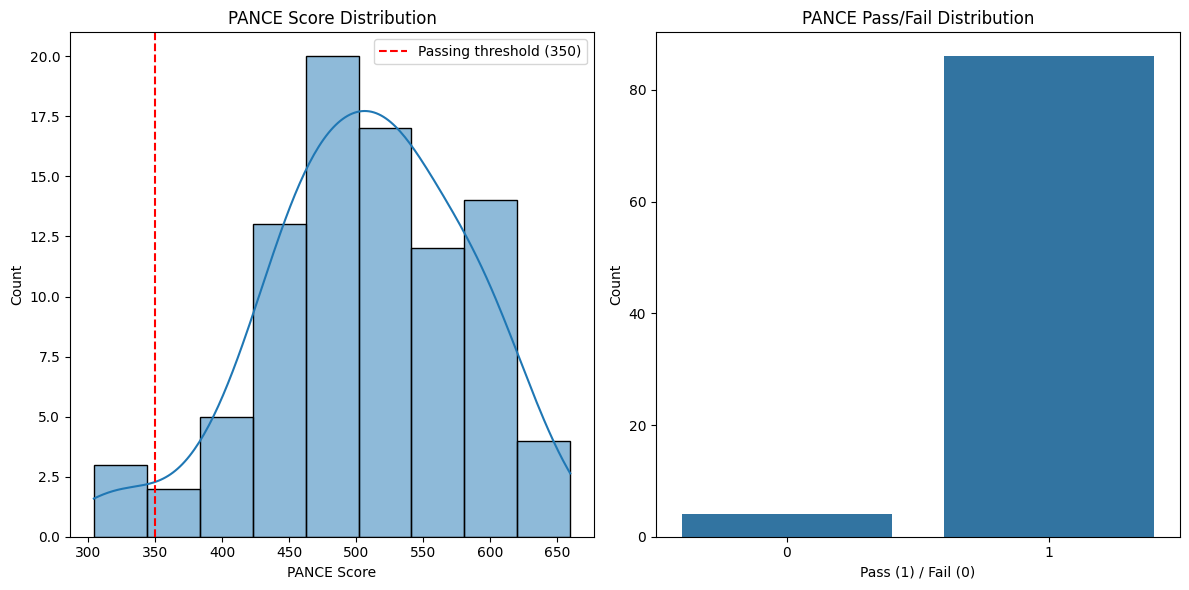

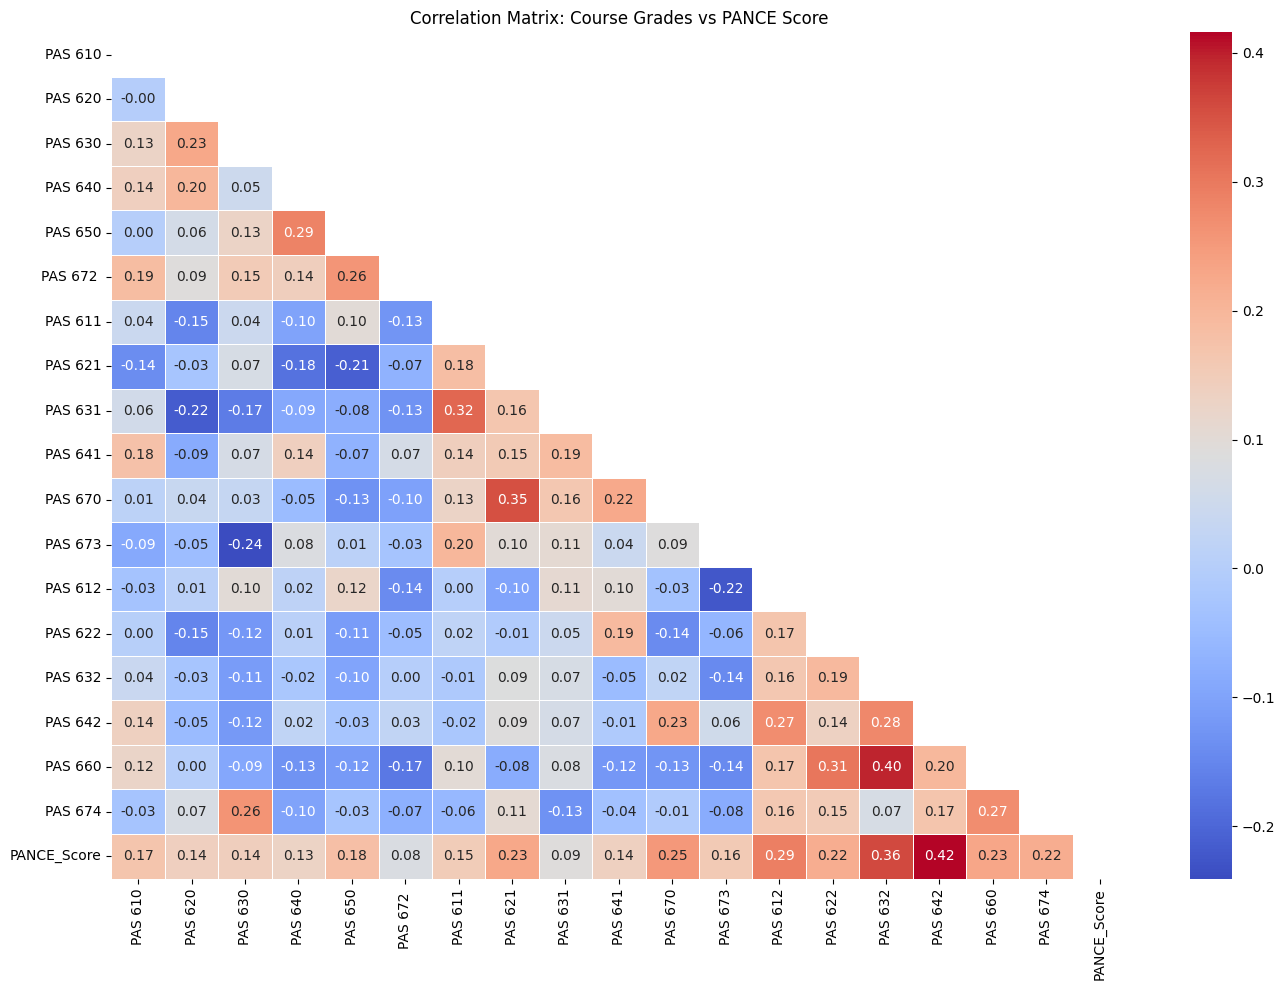

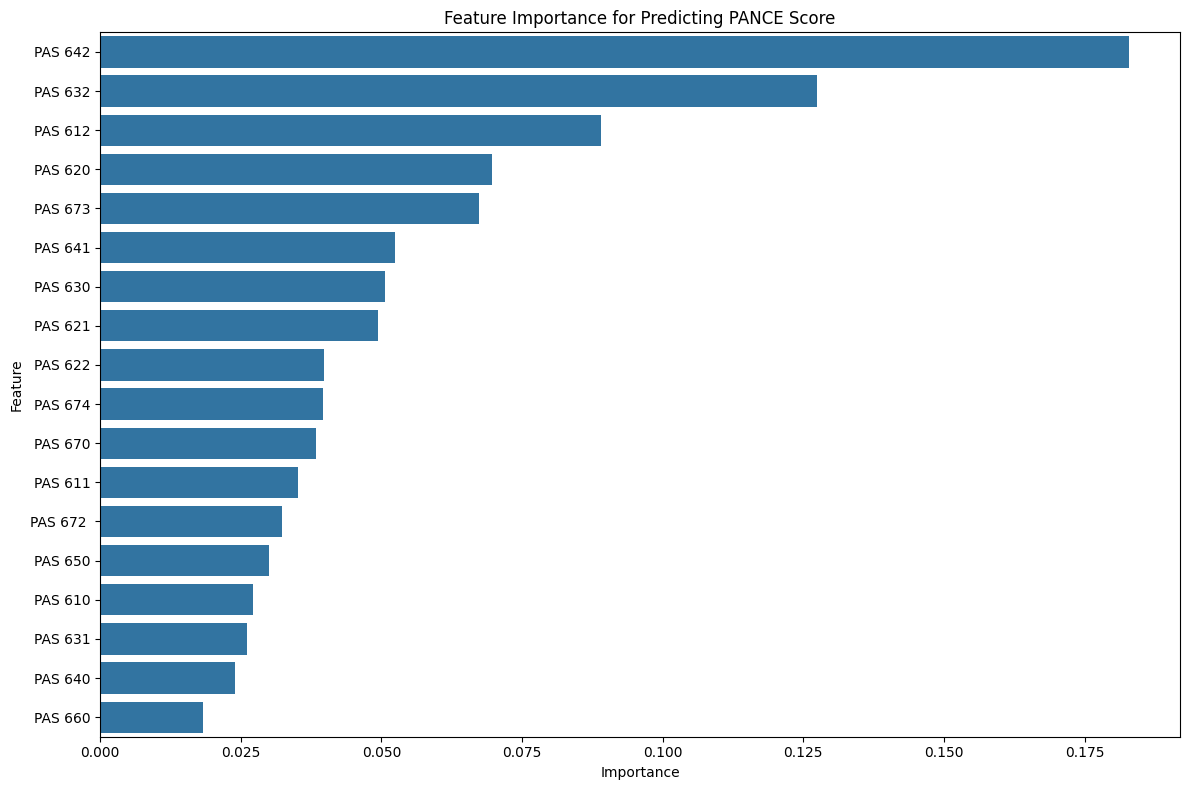

In [13]:
# Function to create visualizations for data exploration
def perform_eda(data):
    print("\n--- EXPLORATORY DATA ANALYSIS ---\n")
    
    # 1. PANCE Score Distribution
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    sns.histplot(data['PANCE_Score'], kde=True)
    plt.axvline(x=350, color='red', linestyle='--', label='Passing threshold (350)')
    plt.title('PANCE Score Distribution')
    plt.xlabel('PANCE Score')
    plt.ylabel('Count')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    sns.countplot(x='PANCE_Pass', data=data)
    plt.title('PANCE Pass/Fail Distribution')
    plt.xlabel('Pass (1) / Fail (0)')
    plt.ylabel('Count')
    
    plt.tight_layout()
    plt.show()
    
    # 2. Correlation between course grades and PANCE scores
    correlation_matrix = data[graded_courses + ['PANCE_Score']].corr()
    
    plt.figure(figsize=(14, 10))
    mask = np.triu(correlation_matrix)
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', mask=mask, fmt='.2f', linewidths=0.5)
    plt.title('Correlation Matrix: Course Grades vs PANCE Score')
    plt.tight_layout()
    plt.show()
    
    # 3. Feature importance analysis
    features = graded_courses
    X = data[features]
    y_score = data['PANCE_Score']
    
    # Use Random Forest for feature importance
    rf_regressor = RandomForestRegressor(n_estimators=100, random_state=RANDOM_SEED)
    rf_regressor.fit(X, y_score)
    
    # Plot feature importances
    importance_df = pd.DataFrame({
        'Feature': features,
        'Importance': rf_regressor.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title('Feature Importance for Predicting PANCE Score')
    plt.tight_layout()
    plt.show()
    
    # Return the most important features
    return importance_df

# Run EDA
importance_df = perform_eda(student_data)

In [14]:
# Display the most important features
print("\nMost Important Courses for Predicting PANCE Score:")
print(importance_df.head(10))


Most Important Courses for Predicting PANCE Score:
    Feature  Importance
15  PAS 642    0.182820
14  PAS 632    0.127510
12  PAS 612    0.089030
1   PAS 620    0.069605
11  PAS 673    0.067396
9   PAS 641    0.052469
2   PAS 630    0.050698
7   PAS 621    0.049457
13  PAS 622    0.039861
17  PAS 674    0.039619



# 3. LOGISTIC REGRESSION MODEL FOR PANCE PASS/FAIL PREDICTION

In [2]:
def build_logistic_regression_model(data, top_features=None):
    print("\n--- LOGISTIC REGRESSION MODEL FOR PASS/FAIL PREDICTION ---\n")
    
    # Prepare the data
    if top_features is None:
        features = graded_courses
    else:
        features = top_features
        
    X = data[features]
    y = data['PANCE_Pass']
    
    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.3, random_state=RANDOM_SEED, stratify=y
    )
    
    # Build the logistic regression model with hyperparameter tuning
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear']
    }
    
    grid_search = GridSearchCV(
        LogisticRegression(random_state=RANDOM_SEED, max_iter=1000),
        param_grid,
        cv=5,
        scoring='accuracy'
    )
    
    grid_search.fit(X_train, y_train)
    
    # Get the best model
    best_model = grid_search.best_estimator_
    print("Best hyperparameters:", grid_search.best_params_)
    
    # Evaluate the model
    y_pred = best_model.predict(X_test)
    
    print("\nModel Performance:")
    print(classification_report(y_test, y_pred))
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Fail', 'Pass'], 
                yticklabels=['Fail', 'Pass'])
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()
    
    # Calculate odds ratios for interpretation
    coef_df = pd.DataFrame({
        'Feature': features,
        'Coefficient': best_model.coef_[0],
        'Odds_Ratio': np.exp(best_model.coef_[0])
    }).sort_values('Odds_Ratio', ascending=False)
    
    print("\nFeature Coefficients and Odds Ratios:")
    print(coef_df)
    
    # Visualize feature coefficients
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Coefficient', y='Feature', data=coef_df.sort_values('Coefficient', ascending=False))
    plt.title('Logistic Regression Coefficients')
    plt.tight_layout()
    plt.show()
    
    return best_model, scaler, features



--- LOGISTIC REGRESSION MODEL FOR PASS/FAIL PREDICTION ---

Best hyperparameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}

Model Performance:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.96      0.96      0.96        26

    accuracy                           0.93        27
   macro avg       0.48      0.48      0.48        27
weighted avg       0.93      0.93      0.93        27



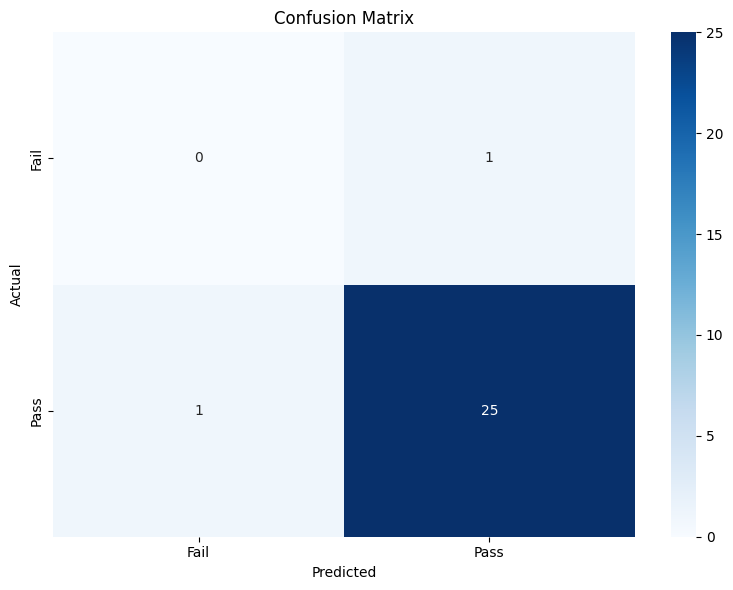


Feature Coefficients and Odds Ratios:
   Feature  Coefficient  Odds_Ratio
4  PAS 673     1.891629    6.630161
2  PAS 612     1.780733    5.934207
5  PAS 641     1.711438    5.536919
8  PAS 622     1.090287    2.975129
0  PAS 642     1.065251    2.901568
1  PAS 632     0.358438    1.431092
6  PAS 630     0.000000    1.000000
7  PAS 621     0.000000    1.000000
9  PAS 674     0.000000    1.000000
3  PAS 620    -0.256568    0.773703


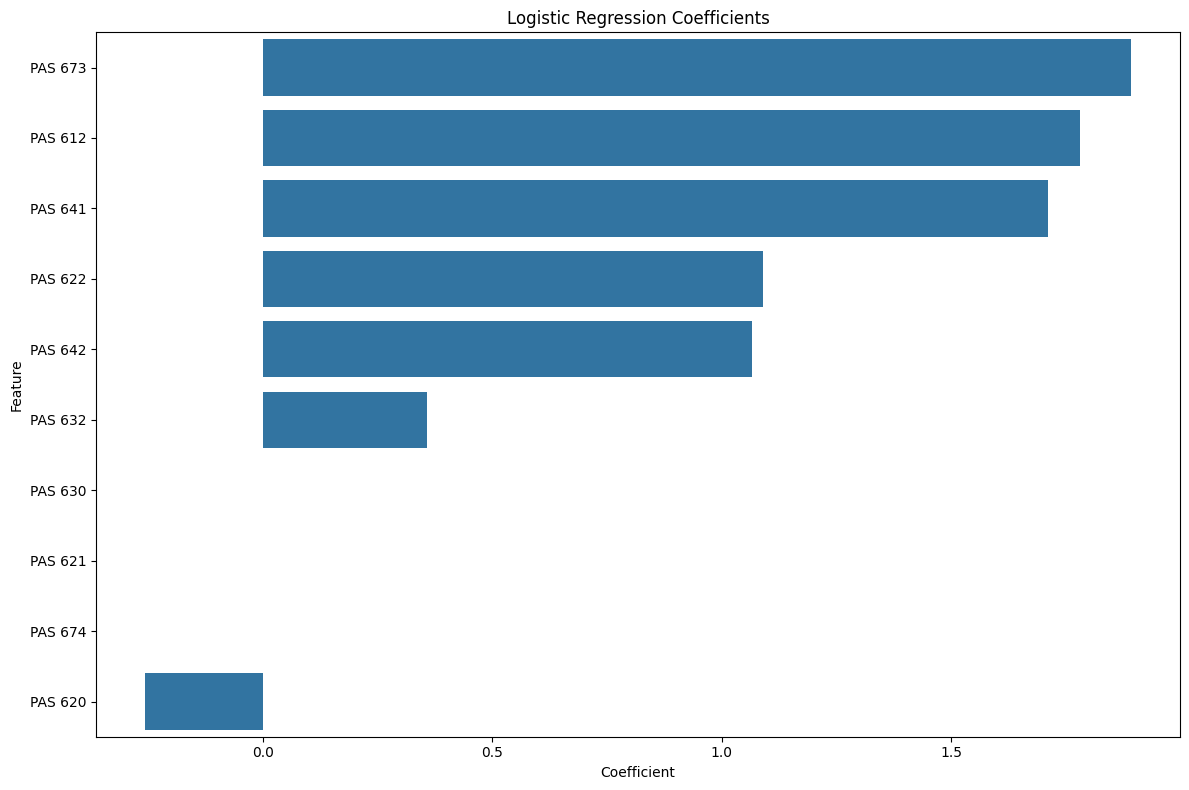

In [16]:
# Get top 10 important features for the models
top_features = importance_df.head(10)['Feature'].tolist()

# Build the logistic regression model
log_reg_model, log_reg_scaler, log_reg_features = build_logistic_regression_model(student_data, top_features)

# 4. LINEAR REGRESSION MODEL FOR PANCE SCORE PREDICTION

In [17]:
def build_linear_regression_model(data, top_features=None):
    print("\n--- LINEAR REGRESSION MODEL FOR PANCE SCORE PREDICTION ---\n")
    
    # Prepare the data
    if top_features is None:
        features = graded_courses
    else:
        features = top_features
        
    X = data[features]
    y = data['PANCE_Score']
    
    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.3, random_state=RANDOM_SEED
    )
    
    # Build the linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Evaluate the model
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"Root Mean Squared Error: {rmse:.2f}")
    print(f"R² Score: {r2:.2f}")
    
    # Plot predicted vs actual values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual PANCE Score')
    plt.ylabel('Predicted PANCE Score')
    plt.title('Actual vs Predicted PANCE Scores')
    plt.tight_layout()
    plt.show()
    
    # Analysis of residuals
    residuals = y_test - y_pred
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    sns.histplot(residuals, kde=True)
    plt.title('Residuals Distribution')
    plt.xlabel('Residual')
    
    plt.subplot(1, 2, 2)
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Residuals vs Predicted Values')
    plt.xlabel('Predicted PANCE Score')
    plt.ylabel('Residual')
    
    plt.tight_layout()
    plt.show()
    
    # Feature coefficients
    coef_df = pd.DataFrame({
        'Feature': features,
        'Coefficient': model.coef_
    }).sort_values('Coefficient', ascending=False)
    
    print("\nFeature Coefficients:")
    print(coef_df)
    
    # Visualize feature coefficients
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Coefficient', y='Feature', data=coef_df.sort_values('Coefficient', ascending=False))
    plt.title('Linear Regression Coefficients')
    plt.tight_layout()
    plt.show()
    
    return model, scaler, features



--- LINEAR REGRESSION MODEL FOR PANCE SCORE PREDICTION ---

Mean Squared Error: 3777.85
Root Mean Squared Error: 61.46
R² Score: 0.08


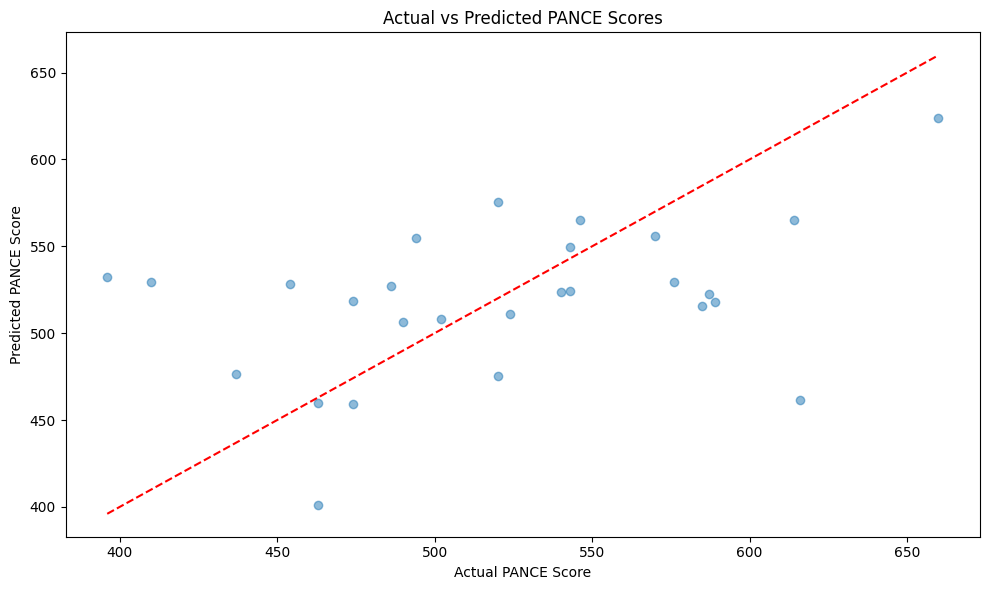

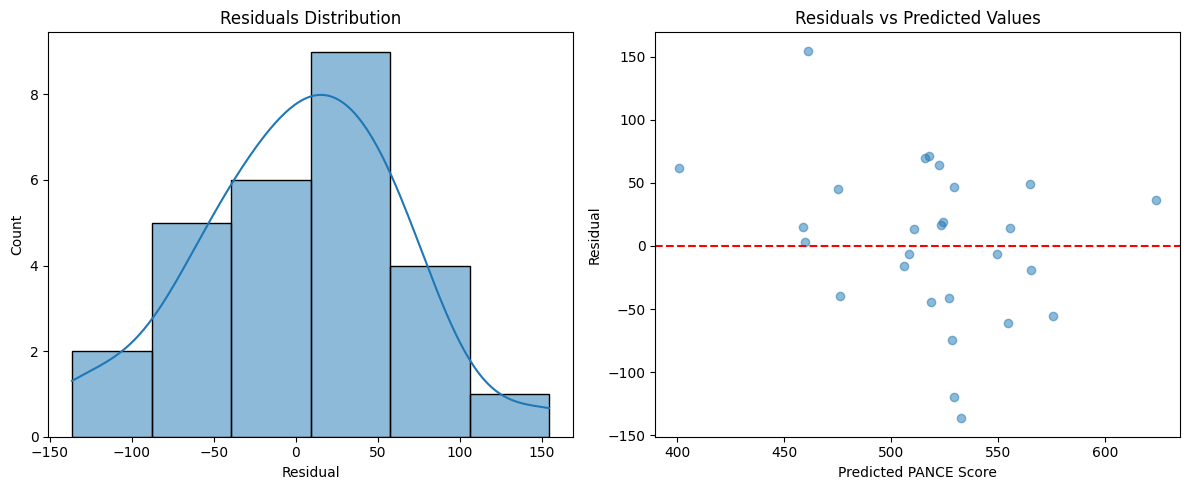


Feature Coefficients:
   Feature  Coefficient
4  PAS 673    21.110767
0  PAS 642    20.830724
8  PAS 622    19.572804
3  PAS 620    18.491041
1  PAS 632    13.512055
2  PAS 612    12.986366
6  PAS 630    11.231904
9  PAS 674     9.134756
7  PAS 621     6.223454
5  PAS 641     3.253208


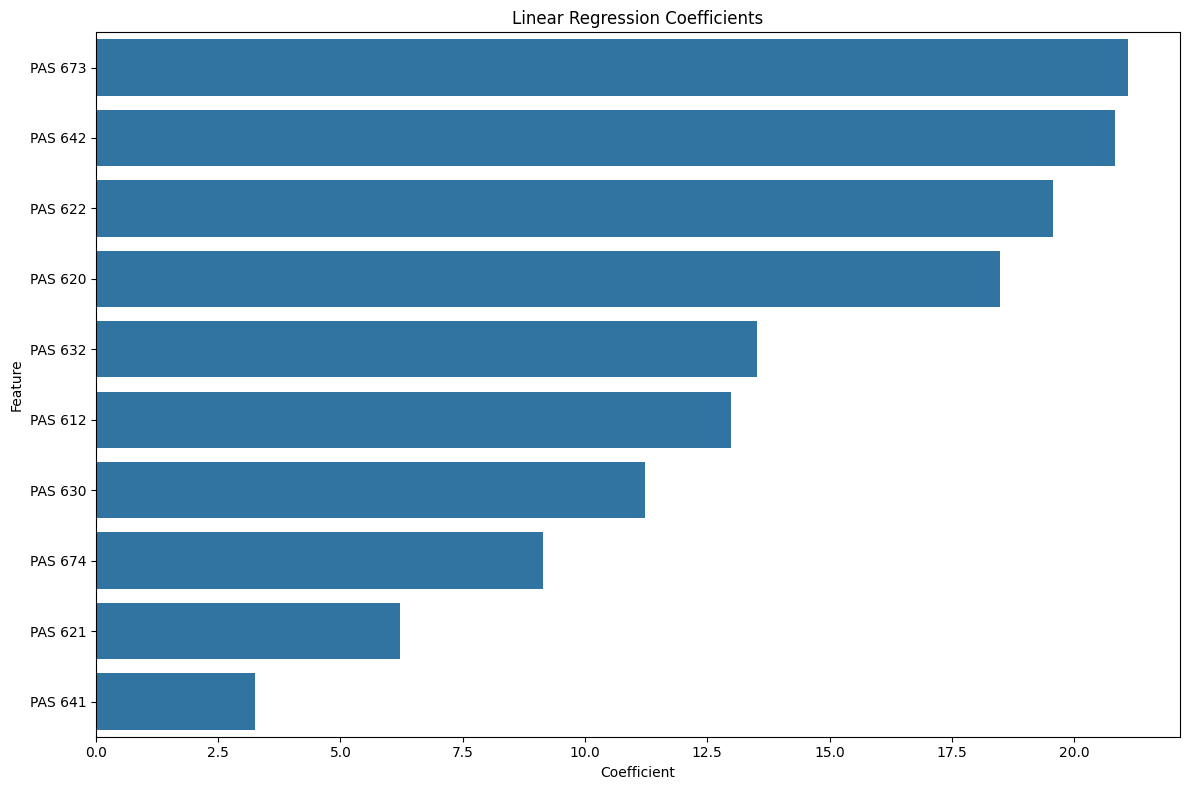

In [18]:
# Build the linear regression model
lin_reg_model, lin_reg_scaler, lin_reg_features = build_linear_regression_model(student_data, top_features)

# 5. RISK STRATIFICATION - DEFINING AT-RISK THRESHOLDS


In [19]:
def develop_risk_stratification(data, lin_reg_model, lin_reg_scaler, lin_reg_features):
    print("\n--- RISK STRATIFICATION MODEL ---\n")
    
    # Use the linear regression model to predict PANCE scores
    X = data[lin_reg_features]
    X_scaled = lin_reg_scaler.transform(X)
    
    # Get predicted PANCE scores
    data['Predicted_PANCE_Score'] = lin_reg_model.predict(X_scaled)
    
    # Calculate prediction error
    data['Prediction_Error'] = data['PANCE_Score'] - data['Predicted_PANCE_Score']
    
    # Set thresholds for risk stratification
    #  These thresholds can be adjusted based on institutional preferences
    
    # Using predicted scores:
    # - "Safe": Predicted score > 400 (well above passing threshold of 350)
    # - "Borderline": Predicted score between 350 and 400
    # - "At-risk": Predicted score < 350
    
    data['Risk_Category'] = pd.cut(
        data['Predicted_PANCE_Score'],
        bins=[0, 350, 400, 1000],
        labels=['At-risk', 'Borderline', 'Safe']
    )
    
    # Analyze the accuracy of our risk categorization
    risk_accuracy = pd.crosstab(
        data['Risk_Category'], 
        data['PANCE_Pass'],
        rownames=['Risk Category'],
        colnames=['Actual Outcome']
    )
    risk_accuracy.columns = ['Failed', 'Passed']
    
    print("Risk Category vs. Actual Outcome:")
    print(risk_accuracy)
    print("\nPercentage of students in each risk category:")
    print(data['Risk_Category'].value_counts(normalize=True) * 100)
    
    # Visualize risk categories vs. actual PANCE scores
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='Risk_Category', y='PANCE_Score', data=data, palette='viridis')
    plt.axhline(y=350, color='red', linestyle='--', label='PANCE Passing Threshold (350)')
    plt.title('PANCE Scores by Risk Category')
    plt.xlabel('Risk Category')
    plt.ylabel('Actual PANCE Score')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Find key grade thresholds in important courses that correlate with risk
    # This helps create a simplified rubric for advisors
    
    # Get the top 3 most important courses
    top_courses = importance_df.head(3)['Feature'].tolist()
    
    risk_thresholds = {}
    simplified_rules = []
    
    for course in top_courses:
        # Find the average grade for each risk category
        course_thresholds = data.groupby('Risk_Category')[course].mean()
        risk_thresholds[course] = course_thresholds
        
        # Create simplified rule
        rule = f"If {course} < {course_thresholds['Borderline']:.1f}, student may be at-risk"
        simplified_rules.append(rule)
    
    print("\nAverage grades by risk category for top courses:")
    for course, thresholds in risk_thresholds.items():
        print(f"\n{course}:")
        print(thresholds)
    
    print("\nSimplified rules for early identification:")
    for rule in simplified_rules:
        print(f"- {rule}")
    
    # Create a more sophisticated risk score using weighted average of grades
    # Normalize weights to sum to 1
    weights = importance_df.set_index('Feature')['Importance']
    weights = weights / weights.sum()
    
    # Calculate weighted grade average using top features
    top_weights = weights.loc[importance_df.head(10)['Feature']]
    normalized_top_weights = top_weights / top_weights.sum()
    
    # Calculate weighted average for each student
    weighted_grades = pd.DataFrame()
    for feature in normalized_top_weights.index:
        weighted_grades[feature] = data[feature] * normalized_top_weights[feature]
    
    data['Weighted_Grade_Average'] = weighted_grades.sum(axis=1)
    
    # Determine risk threshold values from the weighted average
    print("\nWeighted Grade Average distribution:")
    print(data['Weighted_Grade_Average'].describe())
    
    # Calculate thresholds using actual PANCE pass/fail outcomes
    threshold_passing = data[data['PANCE_Pass'] == 1]['Weighted_Grade_Average'].quantile(0.1)
    threshold_safe = data[data['PANCE_Pass'] == 1]['Weighted_Grade_Average'].quantile(0.25)
    
    print(f"\nRecommended risk thresholds based on weighted grade average:")
    print(f"- At-risk threshold: {threshold_passing:.2f}")
    print(f"- Borderline threshold: {threshold_safe:.2f}")
    
    # Apply these thresholds to create a new risk category
    data['Weighted_Risk_Category'] = pd.cut(
        data['Weighted_Grade_Average'],
        bins=[0, threshold_passing, threshold_safe, 100],
        labels=['At-risk', 'Borderline', 'Safe']
    )
    
    # Analyze accuracy of this new categorization
    weighted_risk_accuracy = pd.crosstab(
        data['Weighted_Risk_Category'], 
        data['PANCE_Pass'],
        rownames=['Weighted Risk Category'],
        colnames=['Actual Outcome']
    )
    weighted_risk_accuracy.columns = ['Failed', 'Passed']
    
    print("\nWeighted Risk Category vs. Actual Outcome:")
    print(weighted_risk_accuracy)
    
    # Final risk assessment visualization
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x='Weighted_Grade_Average', 
        y='PANCE_Score', 
        hue='Weighted_Risk_Category',
        palette={'At-risk': 'red', 'Borderline': 'orange', 'Safe': 'green'},
        data=data,
        s=100
    )
    plt.axhline(y=350, color='red', linestyle='--', label='PANCE Passing Threshold (350)')
    plt.axvline(x=threshold_passing, color='orange', linestyle='--', label=f'At-risk Threshold ({threshold_passing:.2f})')
    plt.axvline(x=threshold_safe, color='green', linestyle='--', label=f'Safe Threshold ({threshold_safe:.2f})')
    plt.title('PANCE Scores vs. Weighted Grade Average with Risk Categories')
    plt.xlabel('Weighted Grade Average')
    plt.ylabel('PANCE Score')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
    return data, threshold_passing, threshold_safe


--- RISK STRATIFICATION MODEL ---

Risk Category vs. Actual Outcome:
               Failed  Passed
Risk Category                
Borderline          2       0
Safe                2      86

Percentage of students in each risk category:
Risk_Category
Safe          97.777778
Borderline     2.222222
At-risk        0.000000
Name: proportion, dtype: float64


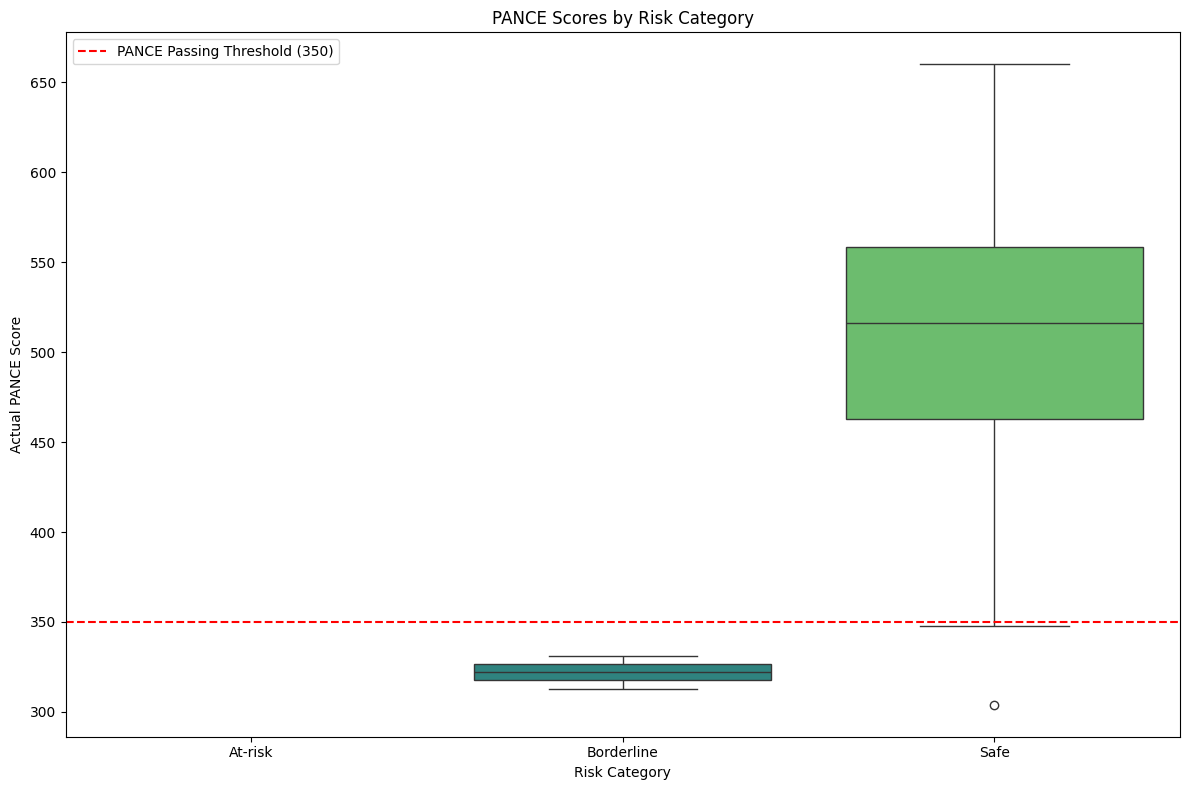


Average grades by risk category for top courses:

PAS 642:
Risk_Category
At-risk             NaN
Borderline    73.450000
Safe          85.235227
Name: PAS 642, dtype: float64

PAS 632:
Risk_Category
At-risk             NaN
Borderline    75.100000
Safe          84.414773
Name: PAS 632, dtype: float64

PAS 612:
Risk_Category
At-risk             NaN
Borderline    69.250000
Safe          84.992045
Name: PAS 612, dtype: float64

Simplified rules for early identification:
- If PAS 642 < 73.4, student may be at-risk
- If PAS 632 < 75.1, student may be at-risk
- If PAS 612 < 69.2, student may be at-risk

Weighted Grade Average distribution:
count    90.000000
mean     84.705025
std       3.421738
min      76.170663
25%      82.203943
50%      84.677833
75%      87.613467
max      92.520542
Name: Weighted_Grade_Average, dtype: float64

Recommended risk thresholds based on weighted grade average:
- At-risk threshold: 81.11
- Borderline threshold: 82.58

Weighted Risk Category vs. Actual Outcome

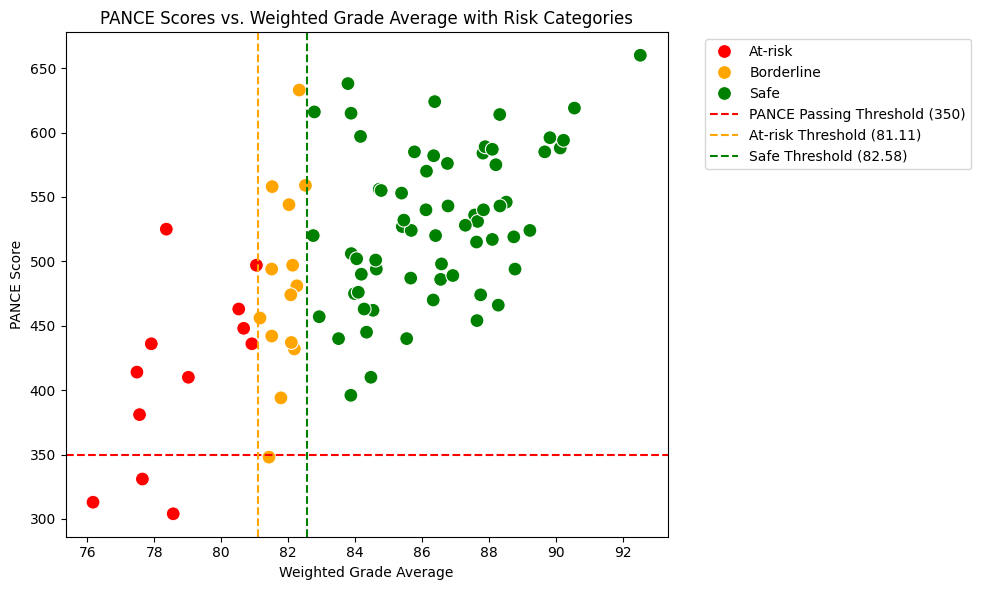

In [20]:
# Develop risk stratification model
risk_data, risk_threshold_low, risk_threshold_high = develop_risk_stratification(
    student_data, lin_reg_model, lin_reg_scaler, lin_reg_features
)

# 6. CREATE PREDICTION FUNCTION FOR NEW STUDENTS

In [21]:
def predict_pance_outcome(grades_dict, log_reg_model, log_reg_scaler, log_reg_features,
                        lin_reg_model, lin_reg_scaler, lin_reg_features,
                        risk_threshold_low, risk_threshold_high):
    """
    Predict PANCE outcomes for a new student based on their course grades.
    
    Parameters:
    -----------
    grades_dict : dict
        Dictionary containing the student's grades with course codes as keys
    log_reg_model, log_reg_scaler, log_reg_features : 
        Trained logistic regression model components
    lin_reg_model, lin_reg_scaler, lin_reg_features : 
        Trained linear regression model components
    risk_threshold_low, risk_threshold_high : float
        Thresholds for risk categorization
        
    Returns:
    --------
    dict
        Dictionary containing prediction results
    """
    # Prepare input data for logistic regression model
    log_reg_input = np.array([grades_dict.get(feature, 0) for feature in log_reg_features]).reshape(1, -1)
    log_reg_input_scaled = log_reg_scaler.transform(log_reg_input)
    
    # Predict pass/fail using logistic regression
    pass_fail_prob = log_reg_model.predict_proba(log_reg_input_scaled)[0, 1]
    pass_fail_prediction = 1 if pass_fail_prob >= 0.5 else 0
    
    # Prepare input data for linear regression model
    lin_reg_input = np.array([grades_dict.get(feature, 0) for feature in lin_reg_features]).reshape(1, -1)
    lin_reg_input_scaled = lin_reg_scaler.transform(lin_reg_input)
    
    # Predict PANCE score using linear regression
    pance_score_prediction = lin_reg_model.predict(lin_reg_input_scaled)[0]
    
    # Calculate weighted grade average for risk assessment
    # Use importance values from the feature importance analysis
    importance_values = importance_df.set_index('Feature')['Importance']
    top_features = importance_df.head(10)['Feature'].tolist()
    top_importance = importance_values.loc[top_features]
    normalized_importance = top_importance / top_importance.sum()
    
    weighted_sum = 0
    for feature in top_features:
        if feature in grades_dict:
            weighted_sum += grades_dict[feature] * normalized_importance[feature]
    
    # Determine risk category
    if weighted_sum < risk_threshold_low:
        risk_category = "At-risk"
    elif weighted_sum < risk_threshold_high:
        risk_category = "Borderline"
    else:
        risk_category = "Safe"
    
    # Return the predictions
    return {
        'Pass_Probability': pass_fail_prob,
        'Pass_Fail_Prediction': 'Pass' if pass_fail_prediction == 1 else 'Fail',
        'PANCE_Score_Prediction': round(pance_score_prediction),
        'Weighted_Grade_Average': weighted_sum,
        'Risk_Category': risk_category
    }

# Test the prediction function with a sample student
sample_student_grades = {course: 85 for course in graded_courses}  # 85 in all courses

print("\n--- SAMPLE PREDICTION FOR A NEW STUDENT ---\n")
print("Sample student with grades of 85 in all courses:")
prediction_result = predict_pance_outcome(
    sample_student_grades,
    log_reg_model, log_reg_scaler, log_reg_features,
    lin_reg_model, lin_reg_scaler, lin_reg_features,
    risk_threshold_low, risk_threshold_high
)

for key, value in prediction_result.items():
    print(f"{key}: {value}")

# Test with another student with lower grades
sample_student_grades_low = {course: 75 for course in graded_courses}  # 75 in all courses

print("\nSample student with grades of 75 in all courses:")
prediction_result_low = predict_pance_outcome(
    sample_student_grades_low,
    log_reg_model, log_reg_scaler, log_reg_features,
    lin_reg_model, lin_reg_scaler, lin_reg_features,
    risk_threshold_low, risk_threshold_high
)

for key, value in prediction_result_low.items():
    print(f"{key}: {value}")


--- SAMPLE PREDICTION FOR A NEW STUDENT ---

Sample student with grades of 85 in all courses:
Pass_Probability: 0.9994861604370032
Pass_Fail_Prediction: Pass
PANCE_Score_Prediction: 511
Weighted_Grade_Average: 84.99999999999999
Risk_Category: Safe

Sample student with grades of 75 in all courses:
Pass_Probability: 0.07997870667856918
Pass_Fail_Prediction: Fail
PANCE_Score_Prediction: 334
Weighted_Grade_Average: 75.00000000000001
Risk_Category: At-risk
